In [3]:
! pip install --quiet environs cyksuid toolz psycopg2-binary typing_json backoff xxhash pyyaml geopandas dtreeviz descartes pysal facebook_business

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [ ]:
# KacperKubara/distython

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 3]

In [3]:
from environs import Env
env = Env()
env.read_env('.env-bug', override=True)

In [ ]:
from adopt.malaria import get_conf, get_df, lookalike
from adopt.marketing import Marketing
from adopt.facebook.state import CampaignState

cnf = get_conf(env)
state = CampaignState(env)
stratum = cnf['strata'][0]
surveys = stratum['surveys']
m = Marketing(env, state)

In [ ]:
import geopandas as gpd
from adopt.malaria import load_cities

def get_dist_info(path):
    geod = gpd.read_file(path)
    district_info = geod.groupby('disthash').apply(lambda df: df.iloc[0][['disthash', 'tot_p']]).reset_index(drop=True)
    return district_info

dist_info = get_dist_info('outs/cluster.shp')
cities = load_cities('output/cities-22.csv')
cities = cities.merge(dist_info, how='left', on='disthash')

districts = cities.groupby('distname') \
                  .head(1) \
                  .reset_index(drop=True) \
                  .drop(columns=['rad', 'lng', 'lat', 'distcode', 'id'])

In [16]:
from adopt.responses import get_forms
from datetime import datetime

survey_user = '10383123-9fb1-429b-8312-447c1b54b17a'
shortcodes = [ 'baselineeng', 'baselinehin', 'baselineodi']

timestamp = datetime(2020, 8, 5)

forms = list(get_forms(survey_user, shortcodes, timestamp, cnf['chatbase']))

In [17]:
questions = [
    ('gender', '20218ad0-96c8-4799-bdfe-90c689c5c206'),
    ('dist_medical', 'd7573919-8a7e-457f-9a1d-1f8c389127a7'),
    ('education', 'e40fa1c6-13a1-4a02-91cd-0eaade11864d'),
    ('age', 'da3d1de1-a287-4143-8b2c-107565a4e4d4'),
    ('religion', '8e490114-df6d-4fb3-b1be-6ce11acd9212'),
    ('caste', '912bc5d8-db4a-402b-b506-f85ce4e89e6f'),
    ('household_size', '8065d101-7995-4471-9ca6-54e9ce6d4310'),
    ('owns_net', 'bd4802c6-7bdb-40f0-aac1-18cc6df7da6e'),
    ('has_ac', 'e279587c-975f-433a-adab-1ad563876af6'),
    ('worried_covid', '25b20f99-a30c-4549-968a-05b7276fa485'),
    ('worried_malaria', '7c955b2b-0480-4cbc-9800-f94b77078f22'),
    ('fever_treatment_seeking', 'f526f205-7aa9-4e3a-9acc-c39766e1bc8c'),
    ('malaria_incidence', 'f6e69027-97cc-494e-8d52-318b75047e23'),
    ('malaria_now', 'dad23031-8468-4900-89cc-d01841d8b660'),
    ('if_malaria_seek_treatment', '73ef8720-5e2b-463c-aa8a-ed890a839a8b'),
    ('if_malaria_tested', '9de3d2f5-d9c0-45aa-9065-a61c975a58dc'),
    ('net_lastnight', 'b5b1ff58-c8df-4890-9b1c-0cd40ce6edc0'),
    ('longsleeves', '0992f107-7274-4404-aeff-bf80a723f098'),
    ('used_spray', '02379921-3b90-4005-b813-cf1e9aec0f40'),
    ('home', '4d0ae478-3893-4b46-ab39-d6848c69245d'), 
    ('occupation', '4fc929c7-132d-49b1-a164-515e5cc9064f')]

In [18]:
from adopt.responses import get_response_df
from datetime import datetime, timezone
from adopt.clustering import only_target_users
import pandas as pd
from adopt.clustering import add_res_cols
from adopt.forms import response_translator
from adopt.malaria import shape_df
import seaborn as sns
import re

def in_time(df, min_date, max_date):
    min_date = datetime(*min_date, tzinfo=timezone.utc)
    max_date = datetime(*max_date, tzinfo=timezone.utc)

    users = df[(df.timestamp > min_date) & (df.timestamp < max_date)].userid.unique()
    return df.userid.isin(users)

def filter_time(df, min_date, max_date):
    return df[in_time(df, min_date, max_date)]

def ref_translation(eng_form, other_form):
    vals = [(a['ref'], b['ref']) for a, b 
            in zip(eng_form['fields'], other_form['fields'])]
    lookup = dict(vals)
    rev_lookup = {v:k for k,v in lookup.items()}
    return lookup, rev_lookup


def get_filtered_responses(survey_user, eng_form, other_form, shortcodes, questions, db_cnf):
    ref_lookup, rev_ref_lookup = ref_translation(eng_form, other_form)
    refs = [ref_lookup[r] for _, r in questions]
    responses = get_response_df(survey_user, shortcodes, refs, db_cnf)

    _, last_ref = questions[-1]
    
    answered = responses[responses.question_ref == last_ref].userid.unique()    

    return responses[responses.userid.isin(answered)].reset_index(drop=True)

def malaria_prob(groupby, key='malaria'):
    d = groupby[key].value_counts(normalize=True)
    d.name = 'count'
    d = d.reset_index(level=-1)
    d = d[d[key] == True].drop(columns=key)
    return d


def stats(df):
    targets = df.kutcha.sum()
    tot = df.shape[0]
    non_target = tot - targets
    return pd.Series([targets/tot, targets, non_target, tot], index=['perc', 'target', 'non_target', 'tot'])


def col_translators(a, b, questions):
    lookup, _ = ref_translation(a, b)

    refs = [ref for _, ref in questions]
    ts = { qt['ref']: response_translator(q, qt)
           for qt, q in zip(a['fields'], b['fields'])
           if qt['ref'] in refs}
    
    return [(n, lookup[ref], ts[ref]) for n, ref in questions]


In [19]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [20]:
filtered_res = get_filtered_responses(survey_user, forms[0], forms[1], ['baselinehin', 'baselinehinexc'], questions, cnf['chatbase'])

col_names = col_translators(forms[0], forms[1], questions)
rr = add_res_cols(col_names, shape_df(filtered_res)) \
    .reset_index(drop=True) \
    .dropna(subset=[r for r, _ in questions if not re.match('if_', r)])

In [ ]:
# choices: 
#   ordered: true
#   alphabetize: true
#   booleanize: Yes

In [21]:
final_clusters = pd.read_csv('outs/final-clusters.csv').disthash

In [22]:
from adopt.forms import make_answers
from pandas.api.types import CategoricalDtype

get_ref = lambda r: next((f for f in forms[0]['fields'] if f['ref'] == r), None)

def fix_homes(dat):
    types = ['Kutcha (made of mud, tin, straw)', 'Semi-pucca', 'Pucca (have cement/brick wall and floor']
    t = CategoricalDtype(categories=types, ordered=True)
    dat['home'] = dat['home'].astype(t)
    return dat

def ordinalize_dat(dat):
    ordinal = ['worried_covid', 'worried_malaria', 'dist_medical', 'education', 'fever_treatment_seeking', 'if_malaria_seek_treatment']
    a = [(make_answers(get_ref(r)), q) for q, r in questions if q in ordinal]
    a = [(q, [l for _, l in li]) for li, q in a ]
    for col, vals in a:
        t = CategoricalDtype(categories=vals, ordered=True)
        dat[col] = dat[col].astype(t)
    return dat

def cast_age(x):
    try: 
        i = int(x)
        if i > 100 or i < 12:
            raise ValueError('impossible age')
        return i
    except ValueError:
        return None

def caste_household(x):
    try:
        i = int(x)
        if i < 0 or i > 30:
            raise ValueError('impossible value')
        return i
    except ValueError:
        return None

def _convert_cat(col):
    try:
        return col.cat.codes
    except AttributeError:
        return None

def convert_cats(df):
    cols = [(col, _convert_cat(df[col])) for col in df.columns]
    cols =  [(n, c) for n, c in cols if c is not None]
    names, cols = zip(*cols)
    return cols

def make_quartile_var(df, var, name):
    df[name] = 'Interquartile'
    df.loc[df[var] >= df[var].quantile(.75), name] = 'Upper Quartile'
    df.loc[df[var] <= df[var].quantile(.25), name] = 'Lower Quartile'
    df[name] = df.dist_risk.astype(CategoricalDtype(categories=['Upper Quartile', 'Interquartile', 'Lower Quartile'], ordered=True))
    return df

def add_mean(df, col, by):
    lookup = dd.groupby(by)[col].mean().reset_index().rename(columns={col: f'mean_{col}'})
    return df.merge(lookup)

def dist_stats(dd):
    for col in ['under_net', 'net_ownership', 'kutcha', 'malaria_now', 'malaria']:
        dd = add_mean(dd, col, 'disthash')
    dd['mean_malaria_2_week'] = dd.mean_malaria_now
    dd['mean_malaria_5_year'] = dd.mean_malaria
    return dd
            
ordinalize = lambda col: col.cat.codes
integerize = lambda col: col.astype(int)
inverse = lambda col: ~col.astype(bool)

dd = rr.merge(districts, left_on='md:clusterid', right_on='disthash')
qrefs = [c for c in dd.columns if len(c) > 35]
dd = dd.drop(columns=qrefs)

dd['under_net'] = dd.net_lastnight == 'Yes'
dd['net_ownership'] = dd.owns_net == 'Yes'
dd['malaria'] = dd.malaria_incidence == 'Yes'
dd['malaria_now'] = dd.malaria_now == 'Yes'
dd['kutcha'] = dd.home == 'Kutcha (made of mud, tin, straw)'
dd['pucca'] = dd.home == 'Pucca (have cement/brick wall and floor'
dd['university'] = dd.education == 'University degree or higher'
dd['unemployed'] = dd.occupation == 'Unemployed'
dd['ac'] = dd.has_ac == 'Yes'
dd['net_ownership'] = dd.owns_net == 'Yes'
dd['disthash'] = dd['md:clusterid']
dd['used_spray'] = dd.used_spray == 'Yes'
dd['general_caste'] = dd.caste == 'General'
dd['lower_caste'] = dd.caste.isin(['OBC', 'SC/Dalit', 'ST'])

dd = dd.groupby('disthash').apply(dist_stats).reset_index(drop=True)

dd['true_age'] = dd.age.map(cast_age)
dd['household'] = dd.household_size.map(caste_household)

dd['lives_alone'] = dd.household <= 1
dd['large_family'] = (dd.household > 8)
dd['student'] = dd.occupation == 'Student'

dd = ordinalize_dat(dd)
dd = fix_homes(dd)
dd['worried_malaria_true'] = dd.worried_malaria.cat.codes < 2

dd = make_quartile_var(dd, 'malaria_now', 'dist_risk')
dd = make_quartile_var(dd, 'malaria', 'dist_risk_5_year')

dd = dd.groupby('disthash').filter(lambda df: df.shape[0] > 100)
dd['male'] = dd.gender == 'Male'

In [23]:
import seaborn as sns

def upd_legend(ax, title, labels):
    l = ax.legend()
    l.set_title(title)
    for t, l in zip(l.texts, labels): 
        t.set_text(l)

sns.set()
base_color = sns.color_palette("Set2")[0]

# Mapping

In [290]:
def plot_incidence_map(dat, cnf, cmap='plasma'):
    fig, ax = plt.subplots(figsize=(10, 10))
    dat.plot(column=cnf['var'], legend=True, ax=ax, cmap=cmap, legend_kwds={'label': cnf['title'], 'orientation': "horizontal", 'shrink': 0.6, 'aspect': 30, 'pad': 0.0})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for s in ax.spines.values():
        s.set_color(None)

In [639]:
  cluster_shapes = gpd.read_file('outs/cluster.shp')
di_shapes = gpd.read_file('outs/districts.shp')

dat = dd.groupby('disthash').mean().reset_index()[['disthash', 'malaria', 'malaria_now']]
dat = dat[dat.disthash.isin(final_clusters)]
dat = cluster_shapes.merge(dat[dat.malaria_now > 0.0], how='right', on='disthash')

In [ ]:
plot_incidence_map(dat, {'var': 'malaria', 'title': '5-year malaria incidence'})
plt.savefig('incidence-map-5-year.png', bbox_inches='tight', dpi=300)

In [ ]:
plot_incidence_map(dat, {'var': 'malaria_now', 'title': '2-week malaria incidence'})
plt.savefig('incidence-map-2-week.png', bbox_inches='tight', dpi=300)

# Misc

In [653]:
# treatment seeking behavior same by home

dd['fever_seek_treatment_rightaway'] = dd.fever_treatment_seeking == 'I would seek treatment right away'
dd.groupby('home').fever_seek_treatment_rightaway.mean()

home
Kutcha (made of mud, tin, straw)           0.709705
Semi-pucca                                 0.714431
Pucca (have cement/brick wall and floor    0.667627
Name: fever_seek_treatment_rightaway, dtype: float64

In [ ]:
sns.barplot(x='under_net', y='home', data=dd, color=base_color)

In [ ]:
dd.plot.scatter(x='mean_under_net', y='mean_malaria_5_year')

In [ ]:
import statsmodels.formula.api as smf

smf.logit('integerize(malaria_now) ~ under_net + mean_malaria_5_year + kutcha + pucca + kutcha*under_net + ac*pucca + ac*kutcha', dd).fit().summary()

In [ ]:
dd[(dd.kutcha & ~dd.net_ownership)]

In [ ]:
smf.logit('integerize(malaria_now) ~ net_ownership + kutcha:inverse(net_ownership):mean_malaria_5_year + mean_malaria_5_year + kutcha + pucca + ac*pucca + ac*kutcha', dd).fit().summary()

In [1716]:
def plot_incidence_barplot(cnf):
    with sns.color_palette(sns.cubehelix_palette(3, start=1.25, rot=.0, dark=0.8, light=.35)):
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.barplot(x=cnf['var'], y=cnf['group'], hue='home', data=dd, ax=ax)
        legend = plt.legend()
        legend.set_title('Dwelling Type')
        ax.set_xlabel(cnf['title'])
        ax.set_ylabel('District Malaria Incidence')        

In [1722]:
dd.groupby(['dist_risk', 'home']).malaria_now.mean()

dist_risk       home                                   
Upper Quartile  Kutcha (made of mud, tin, straw)           0.048176
                Semi-pucca                                 0.027955
                Pucca (have cement/brick wall and floor    0.020103
Interquartile   Kutcha (made of mud, tin, straw)           0.023831
                Semi-pucca                                 0.015422
                Pucca (have cement/brick wall and floor    0.012241
Lower Quartile  Kutcha (made of mud, tin, straw)           0.009407
                Semi-pucca                                 0.000831
                Pucca (have cement/brick wall and floor    0.005503
Name: malaria_now, dtype: float64

In [ ]:
plot_incidence_barplot({'var': 'malaria', 'group': 'dist_risk', 'title': '5-year malaria incidence (household + neighbors)'})

In [ ]:
plot_incidence_barplot({'var': 'malaria', 'group': 'dist_risk_5_year', 'title': '5-year malaria incidence (household + neighbors)'})
plt.savefig('incidence-barplot-5-year.png', bbox_inches='tight', dpi=300)

In [ ]:
plot_incidence_barplot({'var': 'malaria_now', 'title': '2-week malaria incidence (household'})
plt.savefig('incidence-barplot-2-week.png', bbox_inches='tight', dpi=300)

In [ ]:
# Lack of net ownership of people in Kutcha dwellings potentially increases risk
# but those with nets are still very likely to get malaria

with sns.color_palette('Set2'):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(x='malaria_now', y='dist_risk', hue='home', data=dd, ax=ax)
    ax.set_xlabel('2-week malaria incidence')
    # upd_legend(ax, 'Owns Bednet', ['No', 'Yes'])


# leg = ax.legend()

In [ ]:
logit = smf.logit('target ~ mean_malaria_5_year + mean_malaria_2_week + kutcha + pucca + ac', dd.assign(target = dd.malaria_now.astype(int)))

logit = logit.fit()

In [168]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

X = risk[['mean_malaria_5_year', 'mean_malaria_2_week', 'mean_worried_malaria', 'kutcha', 'pucca', 'unemployed', 'true_age']]
ordinal_cols = convert_cats(risk[['dist_medical', 'education']])

X = pd.concat([X, *ordinal_cols], axis=1)
X = X.dropna()

y = risk['worried_malaria'].cat.codes.astype(float)
y = y[X.index]

model = RandomForestRegressor(n_estimators=200, max_depth=4)
preds = cross_val_predict(model, X, y)

model.fit(X, y)

r2_score(y, preds), r2_score(y, model.predict(X))

(0.02433389623401494, 0.03262760964147726)

In [901]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=2)
model.fit(X, y)

from dtreeviz.trees import *

viz = dtreeviz(model, 
               X, 
               y,
               target_name='worried',
               feature_names=X.columns, 
               fancy=False
              )  


In [ ]:
dict(zip(X.columns, cls.feature_importances_))

In [714]:
from sklearn.ensemble import RandomForestClassifier

X = dd[['mean_malaria_5_year', 'mean_malaria_2_week', 'kutcha', 'pucca', 'unemployed']]
ordinal_cols = convert_cats(dd[['dist_medical', 'education']])

X = pd.concat([X, *ordinal_cols], axis=1)

X = X.sample(frac=1.0)
y = dd['malaria_now']
y = y[X.index]

from sklearn.metrics import f1_score, classification_report, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict


cls = RandomForestClassifier(n_estimators=200, max_depth=2, class_weight='balanced')


preds = cross_val_predict(cls, X, y)

print(classification_report(y, preds))
confusion_matrix(y, preds)

              precision    recall  f1-score   support

       False       0.99      0.62      0.76     18712
        True       0.03      0.64      0.05       323

    accuracy                           0.62     19035
   macro avg       0.51      0.63      0.41     19035
weighted avg       0.97      0.62      0.75     19035



array([[11581,  7131],
       [  115,   208]])

In [716]:
cls.fit(X, y)
cls.feature_importances_

array([0.18636787, 0.39749221, 0.18156616, 0.0706766 , 0.00224975,
       0.08928274, 0.07236466])

In [839]:
def predict_risk(dd, cls):
    idx = ~dd.malaria_now
    return dd[idx].reset_index(drop=True).assign(risk_rf = cls.predict_proba(X[idx])[:, 1])

risk = predict_risk(dd, cls)

<ipython-input-839-6e336256903d>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dd[idx].reset_index(drop=True).assign(risk_rf = cls.predict_proba(X[idx])[:, 1])


In [718]:
risk['high_risk'] = risk.risk_rf > .5
risk['high_risk_dist'] = risk.mean_malaria_2_week > risk.mean_malaria_2_week.quantile(0.75) 

In [250]:
risk = risk.groupby('disthash').apply(lambda df: df.assign(mean_worried_malaria = ordinalize(df.worried_malaria).mean()))

In [ ]:
malaria_prob(dd.groupby(['education', 'home']), 'worried_malaria_true')

In [ ]:
smf.ols('ordinalize(worried_malaria) ~ risk_rf', risk).fit().summary()

In [ ]:
smf.ols('ordinalize(worried_malaria) ~ ordinalize(education)*kutcha + mean_malaria_2_week + mean_malaria_5_year + mean_worried_malaria + true_age', risk).fit().summary()

In [ ]:
with sns.color_palette('Set2'):
    ax = sns.barplot(x='worried', y='worried_covid', data=risk.assign(worried=3 - ordinalize(risk.worried_malaria)))
    ax.set_xlabel('Worried about malaria, on a scale of 0-3')
    ax.set_ylabel('Worried about Covid-19')

In [ ]:
with sns.color_palette('Set2'):
    ax = sns.barplot(x='worried', y='home', hue='education', data=risk.assign(worried=3 - ordinalize(risk.worried_malaria)))
    ax.set_xlabel('Worried about malaria, on a scale of 0-3')
    ax.set_ylabel('Home Type')

In [ ]:
with sns.color_palette('Set2'):
    ax = sns.barplot(x='malaria_now', y='home', hue='education', data=dd)
    ax.set_xlabel('Malaria incidence in the last 2 weeks')

In [ ]:
# People are potentially not as worried as they should be

with sns.color_palette('BuGn_r'):
    sns.countplot(y='worried_malaria', data=risk)

In [ ]:

smf.ols('ordinalize(worried_malaria) ~ risk_rf*ordinalize(education)', risk).fit().summary()

In [ ]:
smf.logit('integerize(under_net) ~ ordinalize(worried_malaria)', risk[risk.net_ownership]).fit().summary()

In [ ]:
# little correlation between worried and mean_malaria_2_week

smf.ols('worried_malaria ~ kutcha*mean_malaria_2_week', risk.assign(worried_malaria = risk.worried_malaria.cat.codes)).fit().summary()

In [ ]:
dd.worried_malaria

In [ ]:
smf.ols('mean_malaria_5_year ~ high_risk', risk.assign(worried_malaria = risk.worried_malaria.cat.codes)).fit().summary()

In [ ]:
risk.groupby('high_risk_dist').worried_malaria.value_counts(normalize=True)

In [ ]:
dd.groupby('disthash').apply(lambda df: pd.Series({'not_worried': 1.5 - df.worried_malaria.cat.codes.mean(), 'malaria_now': df.malaria_now.mean()})).plot.scatter(x='not_worried', y='malaria_now')

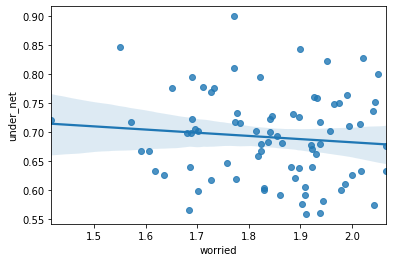

In [864]:
sns.regplot(x='worried', y='under_net', data=dd[(dd.disthash.isin(final_clusters)) & dd.net_ownership].groupby('disthash').apply(lambda df: pd.Series({'worried': df.worried_malaria.cat.codes.mean(), 'under_net': df.under_net.mean()})))

In [ ]:
sns.barplot(y='education', x='malaria_now', data=dd)

In [ ]:
sns.countplot(y='education', hue='worried_malaria', data=dd)

In [772]:
malaria_prob(dd.groupby('education'), 'malaria_now')

,count
education,
Never attended school,0.039851
Primary,0.023821
Secondary,0.016226
University degree or higher,0.015638


In [636]:
risk.groupby('worried_malaria').risk_rf.mean()

worried_malaria
Extremely worried     0.456867
Worried               0.445308
Somewhat worried      0.444504
Not at all worried    0.447429
Name: risk_rf, dtype: float64

In [637]:
risk.groupby('worried_malaria').risk_log.mean()

worried_malaria
Extremely worried     0.018330
Worried               0.017148
Somewhat worried      0.017071
Not at all worried    0.017544
Name: risk_log, dtype: float64

In [537]:


risk.groupby('under_net').risk_rf.mean()

under_net
False    0.437084
True     0.446863
Name: risk_rf, dtype: float64

In [544]:

risk.groupby('under_net').risk_log.mean()

under_net
False    0.016907
True     0.018148
Name: risk_log, dtype: float64

[(0.5, 0.8237569617822164)]

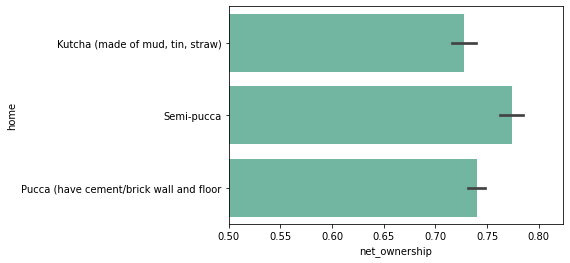

In [558]:
ax = sns.barplot(x='net_ownership', y='home', data=dd, color=base_color)
ax.set(xlim=(.5, None))

In [546]:
risk[risk.net_ownership].groupby('under_net').risk_log.mean()

under_net
False    0.016898
True     0.018008
Name: risk_log, dtype: float64

In [547]:
risk.groupby('longsleeves').risk_log.mean()

longsleeves
No     0.017544
Yes    0.017625
Name: risk_log, dtype: float64

In [540]:
risk.groupby('net_ownership').risk_log.mean()

net_ownership
False    0.017320
True     0.017682
Name: risk_log, dtype: float64

In [448]:
dist_dd = dd.groupby('disthash').head(1).reset_index(drop=True)

In [ ]:
smf.ols('mean_malaria_2_week ~ mean_malaria_5_year - 1', dist_dd).fit().summary()

In [433]:
y = smf.ols('mean_malaria_2_week ~ mean_malaria_5_year - 1', dist_dd).fit().resid

In [ ]:
dist_dd.mean_net_ownership

In [492]:
malaria_prob(dd.groupby('worried_malaria'), 'malaria')

,count
worried_malaria,
Extremely worried,0.203999
Worried,0.222588
Somewhat worried,0.251194
Not at all worried,0.162203


In [496]:
malaria_prob(dd.groupby('worried_malaria'), 'malaria_now')

,count
worried_malaria,
Extremely worried,0.024888
Worried,0.022661
Somewhat worried,0.019387
Not at all worried,0.011648


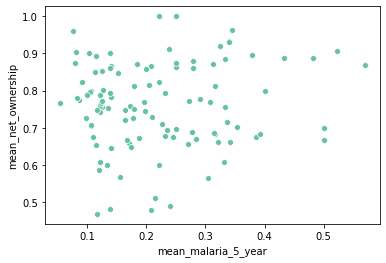

In [488]:
sns.scatterplot(y=dist_dd.mean_net_ownership, x=dist_dd.mean_malaria_5_year, color=base_color)

In [721]:
risk.groupby(['under_net']).risk_rf.mean()

under_net
False    0.463426
True     0.463493
Name: risk_rf, dtype: float64

In [723]:
risk.groupby(['home', 'dist_risk']).risk_rf.mean()

home                                     dist_risk     
Kutcha (made of mud, tin, straw)         Upper Quartile    0.462676
                                         Interquartile     0.468106
                                         Lower Quartile    0.462302
Semi-pucca                               Upper Quartile    0.464711
                                         Interquartile     0.462761
                                         Lower Quartile    0.460111
Pucca (have cement/brick wall and floor  Upper Quartile    0.463952
                                         Interquartile     0.461663
                                         Lower Quartile    0.464765
Name: risk_rf, dtype: float64

0.4691648752336979


<AxesSubplot:xlabel='malaria_risk', ylabel='under_net'>

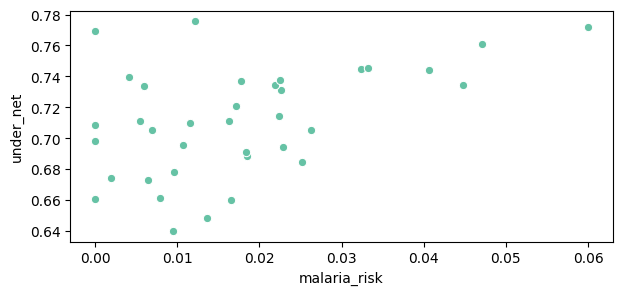

In [1378]:
var = 'under_net'

dat = dd[dd.net_ownership].groupby(['home', 'dist_risk', 'dist_medical']).apply(lambda df: pd.Series({'malaria_risk': df.malaria_now.mean(), 
                                                                                                      var: df[var].mean()})).reset_index()


print(dat.malaria_risk.corr(dat[var]))
sns.scatterplot(x='malaria_risk', y=var, data=dat, color=base_color)

In [ ]:
with sns.color_palette('Set2'):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x='net_ownership', y='dist_risk', hue='occupation', data=risk, ax=ax)
    ax.set_xlabel('Net Ownership')
    ax.set_ylabel('District Malaria Incidence')

In [1052]:
from sklearn.cluster import DBSCAN

dat = dd[['household', 'dist_risk', 'net_ownership', 'ac', 'dist_medical']].copy()
dat['caste']  = 1
dat.loc[dd.lower_caste == True, 'caste'] = 0

ordenals = ['dist_risk', 'dist_medical']

for col in ordenals:
    dat[col] = dat[col].cat.codes

In [31]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dtreeviz.trees import *

cls = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_impurity_decrease=.00005)
X = dd.copy()

y = X['net_ownership']
X = X[['household', 'home', 'ac', 'lower_caste', 'dist_risk', 'student', 'male']]
X = X.dropna()
y = y[X.index]

ordenals = ['home', 'dist_risk']
for col in ordenals:
    X[col] = X[col].cat.codes

cls.fit(X, y)


viz = dtreeviz(cls,
               X, 
               y,
               target_name='owns net',
               feature_names=X.columns, 
               class_names=['no', 'yes']
              )  

In [36]:
dd.lives_alone

31       False
32       False
33        True
34       False
35        True
         ...  
21505    False
21506    False
21507    False
21508     True
21509     True
Name: lives_alone, Length: 20288, dtype: bool

In [ ]:
dd.groupby(['lives_alone']).male.value_counts(normalize=True)

In [ ]:
dd.groupby(['lives_alone', 'student']).male.value_counts(normalize=True)

In [ ]:
dd.groupby(['lives_alone', 'male']).net_ownership.value_counts()

In [33]:
dd.male.mean()

0.9225157728706624

In [ ]:
print(f'N = {X.shape[0]}')

viz

In [46]:
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *


cls = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_impurity_decrease=.0001)
X = dd[(dd.net_ownership == True) & (dd.mean_malaria_now > dd.mean_malaria_now.quantile(0.5))].copy()

y = X['under_net']
X = X[['household', 'home', 'ac', 'lower_caste', 'true_age', 'student', 'male']]
X = X.dropna()
y = y[X.index]

ordenals = ['home']
for col in ordenals:
    X[col] = X[col].cat.codes

cls.fit(X, y)


viz = dtreeviz(cls,
               X, 
               y,
               target_name='under_net',
               feature_names=X.columns, 
               class_names=['no net', 'slept with net']
              )  

In [ ]:
print(f'N = {X.shape[0]}')
viz

In [1535]:
dat = dd[(dd.net_ownership) & (dd.under_net == False) & (dd.mean_malaria_now > dd.mean_malaria_now.quantile(0.5))].reset_index(drop=True)

N = dat.shape[0]
N

2079

In [1536]:
.9 * dat[(dat.lives_alone) & (dat.ac == False) & (~dat.kutcha)].shape[0] / N

0.30822510822510824

In [1537]:
dat[(dat.lives_alone) & (dat.ac == False) & (~dat.kutcha)].true_age.quantile(.05)

17.0

In [1538]:
dat[(dat.lives_alone) & (dat.ac == False) & (~dat.kutcha)].true_age.quantile(.9)

37.0

In [ ]:
dd.home.value_counts(normalize=True)

Pucca (have cement/brick wall and floor    0.492514
Semi-pucca                                 0.258471
Kutcha (made of mud, tin, straw)           0.249015
Name: home, dtype: float64

In [1424]:
dat[(dat.lives_alone) & (dat.ac == False)].home.value_counts(normalize=True)

Pucca (have cement/brick wall and floor    0.545151
Semi-pucca                                 0.248606
Kutcha (made of mud, tin, straw)           0.206243
Name: home, dtype: float64

In [1418]:
dat[(~dat.lives_alone) & (dat.ac == False) & (dat.lower_caste)].shape[0]

556

In [1436]:
dat[(~dat.lives_alone) & (dat.ac == False) & (dat.lower_caste)].shape[0] / N

0.2674362674362674

In [1442]:
dat[(~dat.lives_alone) & (dat.ac == False) & (~dat.pucca | dat.lower_caste)].shape[0] / N

0.37373737373737376

In [1476]:
dd.true_age.quantile(.9)

36.0

In [1539]:
.9 * dat[(~dat.lives_alone) & (dat.ac == False) & (dat.kutcha | dat.lower_caste)].shape[0] / N

0.28744588744588745

In [1552]:
dd[~dd.lives_alone].large_family.mean()

0.11951788491446345

In [1550]:
dat[(~dat.lives_alone)].large_family.mean()

0.05555555555555555

In [1546]:
dat[(~dat.lives_alone) & (dat.ac == False) & (dat.kutcha | dat.lower_caste)].large_family.mean()

0.058734939759036146

In [1553]:
.9 * dat[(~dat.lives_alone) & (dat.ac == False) & (dat.kutcha | dat.lower_caste) & (~dat.large_family)].shape[0] / N

0.27056277056277056

In [1463]:
dat[(~dat.lives_alone) & (dat.ac == False) & (dat.kutcha | dat.lower_caste)].true_age.quantile(.1)

18.0

In [1477]:
dat[(~dat.lives_alone) & (dat.ac == False) & (dat.kutcha)].true_age.quantile(.9)

29.0

In [1444]:
dat[(~dat.lives_alone) & (dat.ac == False) & (dat.lower_caste) & (~dat.pucca)].shape[0] / N

0.16354016354016354

In [1422]:
dat[(~dat.lives_alone)].home.value_counts()

Pucca (have cement/brick wall and floor    461
Semi-pucca                                 312
Kutcha (made of mud, tin, straw)           289
Name: home, dtype: int64

In [1390]:
dat[(dat.lives_alone)].shape[0]

1017

In [ ]:
dat[(dat.lives_alone)].shape[0]

In [1394]:
with pd.option_context('display.max_rows', None, 'display.expand_frame_repr', False):
    display(dd[(dd.ac == False) & (dd.net_ownership) & (dd.under_net == False) & (dd.mean_malaria_now > dd.mean_malaria_now.quantile(0.5))].groupby(['lives_alone', 'large_family', 'home', 'lower_caste']).count().userid.sort_values(ascending=False))

lives_alone  large_family  home                                     lower_caste
True         False         Pucca (have cement/brick wall and floor  True           255.0
                                                                    False          234.0
False        False         Pucca (have cement/brick wall and floor  True           202.0
                                                                    False          181.0
                           Semi-pucca                               True           165.0
                           Kutcha (made of mud, tin, straw)         True           156.0
True         False         Semi-pucca                               True           136.0
False        False         Semi-pucca                               False          109.0
True         False         Kutcha (made of mud, tin, straw)         True           107.0
False        False         Kutcha (made of mud, tin, straw)         False          102.0
True         False         Sem

In [ ]:
with sns.color_palette(sns.cubehelix_palette(3, start=1.25, rot=.0, dark=0.8, light=.35)):
    sns.barplot(y='dist_risk', hue='home', x='under_net', data= dd[dd.net_ownership])

In [1520]:
N = dd[~dd.net_ownership].shape[0]

In [1521]:
dd[~dd.net_ownership & (dd.lives_alone == True) & (dd.student == False) & (dd.ac == False)].true_age.quantile(.95)

48.0

In [1492]:
dd.gender.value_counts(normalize=True)

Male      0.923614
Female    0.072971
Other     0.003415
Name: gender, dtype: float64

In [1523]:
.9 * dd[~dd.net_ownership & (dd.lives_alone == True) & (dd.student == False) & (dd.ac == False) & (dd.gender)].shape[0] / N

0.4472804190169219

In [1524]:
dd[~dd.net_ownership & (dd.lives_alone == False) & (dd.large_family == False) & (dd.ac == False)].shape[0] / N

0.2127316680096696

In [1525]:
dd[~dd.net_ownership &  (dd.lives_alone == False) & (dd.ac == False) & (dd.large_family == False) & ((~dd.pucca))].shape[0] / N

0.13215149073327961

In [1526]:
dd[~dd.net_ownership &  (dd.lives_alone == False) & (dd.ac == False) & (dd.large_family == False) & ((dd.lower_caste))].shape[0] / N

0.11059629331184528

In [ ]:
dd.home.value_counts(normalize=True)

In [ ]:
dd[~dd.net_ownership &  (dd.lives_alone == False) & (dd.ac == False) & (dd.large_family == False) & (~(dd.lower_caste))].home.value_counts(normalize=True)

In [1533]:
dd[~dd.net_ownership &  (dd.lives_alone == False) & (dd.ac == False) & (dd.large_family == False) & ((dd.kutcha) | (dd.lower_caste))].true_age.quantile(.05)

16.0

In [1534]:
dd[~dd.net_ownership &  (dd.lives_alone == False) & (dd.ac == False) & (dd.large_family == False) & ((dd.kutcha) | (dd.lower_caste))].shape[0] / N

0.14645447219983884

In [ ]:
dd[~dd.net_ownership &  (dd.lives_alone == False) & (dd.ac == False) & (dd.large_family == False)].shape[0] / N

0.2127316680096696

In [ ]:
dd[~dd.net_ownership & (dd.lives_alone == False) & (dd.ac == False) & (dd.household < 10)].household.value_counts()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.expand_frame_repr', False):
    display(dd[~dd.net_ownership].groupby(['lives_alone', 'large_family', 'home', 'ac', 'lower_caste', 'student']).count().userid.sort_values(ascending=False))

In [ ]:
dd[(dd.under_net == False) & (dd.dist_risk == 'Upper Quartile')]

In [ ]:
# 33% report living alone
sns.distplot(dat, kde=False, bins=20, color=base_color, hist_kws={'alpha': 1})

In [ ]:
# Interquartile range (middle 50%) between 21-29 years old
sns.distplot(dd.true_age, color=base_color, kde=False, hist_kws={'alpha': 1})

In [ ]:
# 59% have a university degree or higher
sns.countplot(y='education', data=dd, color=base_color)

In [ ]:
# 45% report being unemployed, 25% report being students
sns.countplot(y='occupation', data=dd, color=base_color)

In [ ]:
with sns.color_palette(sns.cubehelix_palette(6, start=1.5, rot=-1, dark=0.3, light=.8)):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x='net_ownership', y='dist_risk_5_year', hue='education', data=risk, ax=ax)
    ax.set_xlabel('Net Ownership')
    ax.set_ylabel('District Malaria Incidence')

In [1740]:
dd.groupby('disthash').agg({'net_ownership': np.mean, 'malaria_now': np.mean}).corr()

,net_ownership,malaria_now
net_ownership,1.000000,0.047535
malaria_now,0.047535,1.000000


In [ ]:
dd.groupby('disthash').agg({'net_ownership': np.mean, 'malaria_now': np.mean, 'malaria': np.mean}).plot.scatter(x='net_ownership', y='malaria_now')

In [ ]:
ax = sns.distplot(dd.groupby('disthash').net_ownership.mean(), color=base_color, bins=20, hist_kws={'alpha': 1}, kde=False)
ax.set_xlabel('Mean net ownership by district')

In [1353]:
dd.groupby(['lives_alone', 'student']).net_ownership.mean()

lives_alone  student
False        False      0.892333
             True       0.902987
True         False      0.391729
             True       0.489041
Name: net_ownership, dtype: float64

In [1352]:
dd.groupby(['large_family', 'lives_alone']).net_ownership.mean()

large_family  lives_alone
False         False          0.895522
              True           0.414737
True          False          0.891347
Name: net_ownership, dtype: float64

In [1349]:
dd.groupby('disthash').net_ownership.mean().quantile(.75)

0.8116090065284007

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x='net_ownership', y='dist_risk', data=risk, ax=ax, color=base_color)
ax.set_xlabel('Net Ownership')
ax.set_ylabel('District Malaria Incidence')
ax.set_xlim(0.5, None)

In [ ]:
with sns.color_palette(sns.cubehelix_palette(6, start=1.5, rot=-1, dark=0.3, light=.8)):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x='net_ownership', y='dist_risk', hue='education', data=risk, ax=ax)
    ax.set_xlabel('Net Ownership')
    ax.set_ylabel('District Malaria Incidence')

In [ ]:
# likelihood of sleeping under a net, given that they have one, rather consistent
with sns.color_palette(sns.cubehelix_palette(6, start=1.5, rot=-1, dark=0.3, light=.8)):
    sns.barplot(x='under_net', y='dist_risk', hue='education', data=risk[risk.net_ownership])

In [ ]:
dat = dd.groupby(['home', 'dist_risk', 'dist_medical']).apply(lambda df: pd.Series({'malaria_risk': df.malaria_now.mean(), 
                                                                                    var: df[var].mean()})).reset_index()

In [727]:
dd.groupby(['home', 'dist_risk']).net_ownership.mean()

home                                     dist_risk     
Kutcha (made of mud, tin, straw)         Upper Quartile    0.748107
                                         Interquartile     0.703237
                                         Lower Quartile    0.704610
Semi-pucca                               Upper Quartile    0.777157
                                         Interquartile     0.763393
                                         Lower Quartile    0.773256
Pucca (have cement/brick wall and floor  Upper Quartile    0.752780
                                         Interquartile     0.735589
                                         Lower Quartile    0.715802
Name: net_ownership, dtype: float64

In [ ]:
dd[dd.net_ownership].groupby(['home', 'dist_risk']).longsleeves.value_counts(normalize=True)

In [ ]:
dd[dd.net_ownership].groupby(['home', 'dist_risk']).used_spray.mean()

In [ ]:
dd[dd.net_ownership].groupby(['home', 'dist_risk']).under_net

In [ ]:
sns.barplot('under_net', 'dist_risk', hue='home', data=dd[dd.net_ownership])

In [ ]:
risk.groupby(['under_net']).risk_rf.mean()

In [483]:
dd.groupby(['home', 'net_ownership']).count().surveyid

home                                     net_ownership
Kutcha (made of mud, tin, straw)         False            1405
                                         True             3763
Semi-pucca                               False            1178
                                         True             4029
Pucca (have cement/brick wall and floor  False            2549
                                         True             7258
Name: surveyid, dtype: int64

In [481]:
malaria_prob(dd.groupby(['home', 'net_ownership']), 'under_net')

count
home                                    net_ownership          
Kutcha (made of mud, tin, straw)        False          0.155160
                                        True           0.748339
Semi-pucca                              False          0.078947
                                        True           0.709109
Pucca (have cement/brick wall and floor False          0.067085
                                        True           0.682557

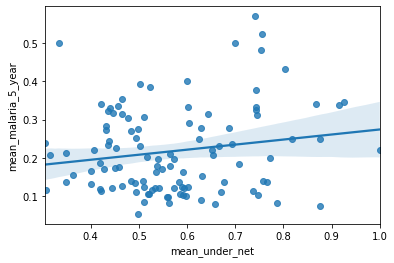

In [436]:
sns.regplot(y=dist_dd.mean_malaria_5_year, x=dist_dd.mean_under_net)

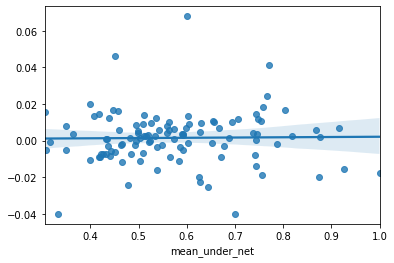

In [434]:
sns.regplot(y=y, x=dist_dd.mean_under_net)

In [ ]:
dd.net_ownership

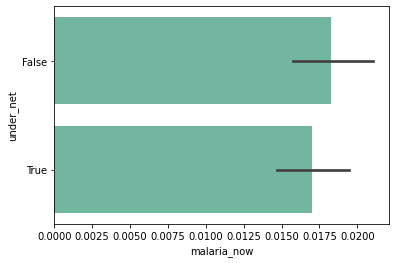

In [446]:
malaria_prob(dd.groupby('under_net'), 'malaria_now')

sns.barplot(y='under_net', x='malaria_now', data=dd, orient='h', color=base_color)

In [ ]:
forms[0]

In [ ]:
# dd.groupby("home").used_spray.value_counts(normalize=True)

sns.barplot(x='used_spray', y='home', data=dd.assign(used_spray = dd.used_spray == 'Yes'), color=base_color)

In [ ]:
forms[0]

,index,fever_treatment_seeking
0,I would seek treatment right away,0.690202
1,I would seek treatment if the fever didn’t sub...,0.182558
2,I don’t think it is necessary to seek treatmen...,0.070607
3,I would wait and see how the fever develops ov...,0.056633


In [675]:
dd.fever_seek_treatment_rightaway.mean()

0.6902022589965853

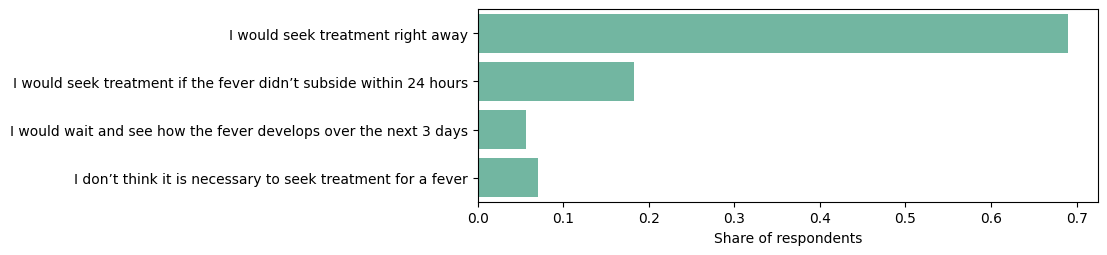

In [1334]:

with sns.color_palette(sns.cubehelix_palette(3, start=1.25, rot=.0, dark=0.8, light=.35)):
    fig, ax = plt.subplots(figsize=(8,2.5))
    dat = dd.fever_treatment_seeking.value_counts(normalize=True)
    dat = dat.reset_index()
    sns.barplot(y='index', x='fever_treatment_seeking', data=dat, color=base_color)
    ax.set_ylabel('')
    ax.set_xlabel('Share of respondents')

plt.savefig('treatment-seeking.png', bbox_inches='tight', dpi=300)

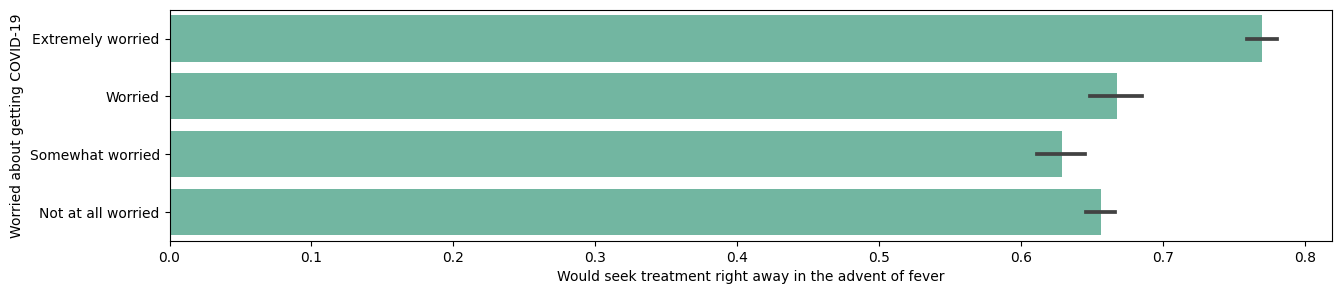

In [688]:
# worries about covid seem to be positively correlated with treatment seeking attitudes. 

with sns.color_palette(sns.cubehelix_palette(3, start=1.25, rot=.0, dark=0.8, light=.35)):
    fig, ax = plt.subplots(figsize=(15,3))
    sns.barplot(x='fever_seek_treatment_rightaway', y='worried_covid', color=base_color, data=dd, ax=ax)
    ax.set_ylabel('Worried about getting COVID-19')
    ax.set_xlabel('Would seek treatment right away in the advent of fever')

plt.savefig('covid-treatment-seeking.png', bbox_inches='tight', dpi=300)

In [ ]:
sns.barplot(x='fever_seek_treatment_rightaway', y='home', data=dd, color=base_color)

In [ ]:
sns.barplot(x='fever_seek_treatment_rightaway', y='worried_malaria', data=dd, color=base_color)

In [ ]:
# treatment seeking same by district risk

dd.groupby('fever_seek_treatment_rightaway').mean_malaria_5_year.mean()

fever_seek_treatment_rightaway
False    0.200064
True     0.193914
Name: mean_malaria_5_year, dtype: float64

In [ ]:
sns.swarmplot(x = 'if_malaria_tested', y = 'mean_malaria_5_year', data=dd)

In [ ]:
sns.swarmplot(x = 'if_malaria_seek_treatment', y = 'mean_malaria_5_year', data=dd)

In [1577]:
dd.groupby(['home', 'dist_medical']).malaria_now.mean()

home                                     dist_medical             
Kutcha (made of mud, tin, straw)         Less than 15 minutes         0.025169
                                         Between 15 and 30 minutes    0.025962
                                         Between 30 and 60 minutes    0.029273
                                         More than 60 minutes         0.030473
Semi-pucca                               Less than 15 minutes         0.010277
                                         Between 15 and 30 minutes    0.011218
                                         Between 30 and 60 minutes    0.015094
                                         More than 60 minutes         0.023014
Pucca (have cement/brick wall and floor  Less than 15 minutes         0.010996
                                         Between 15 and 30 minutes    0.010010
                                         Between 30 and 60 minutes    0.011124
                                         More than 60 minutes   

In [ ]:
sns.barplot(x='malaria_now', y='home', hue='dist_medical', data=dd)

In [1559]:
(dd[dd.malaria_now].if_malaria_tested == 'Yes').mean()

0.5294117647058824

In [1572]:
dd[dd.malaria_now & dd.if_malaria_seek_treatment.notna()].if_malaria_seek_treatment.value_counts(normalize=True)

Less than 24 hours    0.654971
24-48 hours           0.198830
More than 2 days      0.146199
Name: if_malaria_seek_treatment, dtype: float64

In [ ]:
malaria_prob(dd.groupby('home'), 'malaria_now')

In [ ]:
dd[['mean_bednet', 'mean_malaria_5_year', 'disthash']].groupby('disthash').head(1).corr()

In [ ]:
# district fixed effects of kutcha

def kutcha_dif(df):
    a = df[df.kutcha == True].iloc[0]['count']
    b = df[df.kutcha == False].iloc[0]['count']
    return a - b

malaria_prob(dd.groupby(['disthash', 'kutcha']), 'malaria_now').reset_index() \
    .groupby('disthash') \
    .filter(lambda df: df.shape[0] > 1) \
    .groupby('disthash') \
    .apply(kutcha_dif).mean()

# Spatial Autocorrelation

In [1759]:
import libpysal
import esda


gdf = gpd.read_file('outs/cluster.shp')
gdf = gdf[gdf.geometry.notna()]
gdf = gdf.to_crs(3857) 

dist_shapes = gdf.groupby('disthash').apply(lambda df: df.geometry.unary_union)
dist_shapes = gpd.GeoDataFrame(dist_shapes.reset_index().rename(columns={0: 'geometry'}))

dist_stats = dd[dd.disthash.isin(final_clusters)].groupby('disthash').mean().reset_index()
dist_shapes = dist_shapes.merge(dist_stats)
wnn = libpysal.weights.KNN.from_dataframe(dist_shapes, k=3)


In [1768]:
mi = esda.moran.Moran(dist_shapes['mean_malaria'], wnn)
mi.I

0.3878159251073957

In [1769]:
mi = esda.moran.Moran(dist_shapes['mean_malaria_now'], wnn)
mi.I

0.19119790275382118

# Effects of Recruitment Optimization

In [65]:
dat = dd[dd.disthash.isin(final_clusters)].reset_index(drop=True)

In [66]:
filter_time(dat, (2020, 7,1), (2020,8,1)).groupby('disthash').kutcha.mean().quantile(.63)

0.2

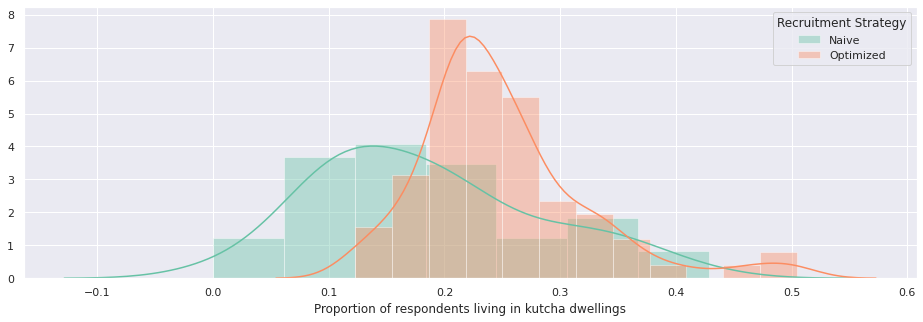

In [255]:
with sns.color_palette('Set2'):
    _, ax = plt.subplots(figsize=(16, 5))
    sns.distplot(filter_time(dat, (2020, 7,1), (2020,8,1)).groupby('disthash').kutcha.mean())
    sns.distplot(filter_time(dat, (2020, 7,1), (2020,9,1)).groupby('disthash').kutcha.mean())
    leg = ax.legend(title='Recruitment Strategy', labels=['Naive', 'Optimized'])    
    ax.set_xlabel('Proportion of respondents living in kutcha dwellings')

plt.savefig('optimization-kutcha-proportion.png', bbox_inches='tight', dpi=300)

In [68]:
dat['recruitment'] = 'Naive'
dat.loc[in_time(dat, (2020, 8,1), (2020,9,1)), 'recruitment'] = 'Optimized'

In [110]:
filter_time(dat, (2020, 7,1), (2020,8,1)).groupby('home').malaria_now.mean()

home
Kutcha (made of mud, tin, straw)           0.035211
Semi-pucca                                 0.013875
Pucca (have cement/brick wall and floor    0.008420
Name: malaria_now, dtype: float64

In [256]:
filter_time(dat, (2020, 7,1), (2020,8,1)).groupby('disthash').kutcha.mean().mean()

0.18450930975065866

In [257]:
filter_time(dat, (2020, 7,1), (2020,9,1)).groupby('disthash').kutcha.mean().mean()

0.24964053340133172

In [270]:
(filter_time(dat, (2020, 7,1), (2020,8,1)).groupby('disthash').kutcha.mean() < 0.1).sum()

13

In [271]:
(filter_time(dat, (2020, 7,1), (2020,9,1)).groupby('disthash').kutcha.mean() < 0.1).sum()

0

In [265]:
filter_time(dat, (2020, 7,1), (2020,8,1)).groupby('disthash').kutcha.mean().quantile(0.05)

0.056405163853028795

In [267]:
filter_time(dat, (2020, 7,1), (2020,9,1)).groupby('disthash').kutcha.mean().quantile(0.0)

0.12272727272727273

In [ ]:
filter_time(dat, (2020, 8,1), (2020,9,1)).groupby('disthash').kutcha.mean().quantile(.9)

In [111]:
filter_time(dat, (2020, 7,1), (2020,8,1)).kutcha.mean()

0.16852599098029908

In [314]:
dd.home.value_counts()

Pucca (have cement/brick wall and floor    9437
Semi-pucca                                 4955
Kutcha (made of mud, tin, straw)           4792
Name: home, dtype: int64

In [316]:
dd['semipucca'] = dd['home'] == 'Semi-pucca'

In [318]:
dd.groupby('disthash').semipucca.mean().min()

0.1434108527131783

In [112]:
filter_time(dat, (2020, 8,1), (2020,9,1)).kutcha.mean()

0.2717681715420977

In [129]:
from adopt.clustering import get_budget_lookup, prep_df_for_budget, calc_price
from adopt.malaria import window, days_left, get_df, get_cluster_from_adset
from adopt.facebook.state import CampaignState, BudgetWindow

w = BudgetWindow(datetime(2020,8,1), datetime.now())
state = CampaignState(env, w)

spend = {get_cluster_from_adset(n): i
         for n, i in state.spend.items()}

In [ ]:
df = get_df(cnf)
stratum = cnf['strata'][0]

In [143]:
completed_df = prep_df_for_budget(df, stratum)

In [144]:
price = calc_price(completed_df, w, spend)
price = {k:v/100 for k, v in price.items()}

In [146]:
from adopt.malaria import get_cluster_from_adset

def prep_facebook_data(path, dd, final_clusters):
    capture_count = dd[(dd.timestamp > datetime(2020,7,23,tzinfo=timezone.utc)) & 
                       (dd.timestamp < datetime(2020,7,24,tzinfo=timezone.utc))] \
        .groupby('disthash') \
        .userid.count() \
        .reset_index() \
        .rename(columns={'userid': 'completed_survey'})

    df = pd.read_csv(path)
    df['disthash'] = df['Ad Set Name'].map(get_cluster_from_adset)
    df = df.merge(capture_count, how='left')
    df = df[df.disthash.isin(final_clusters)].reset_index(drop=True)

    spend = 'Amount Spent (INR)'
    df['cost_per_completion'] = df.apply(lambda r: r[spend] / r.completed_survey, 1)
    df = df.rename(columns = {'CTR (All)': 'CTR', 
                              'Cost per Results': 'cost_per_message', 
                              'CPM (Cost per 1,000 Impressions) (INR)': 'CPM'})

    return df[['disthash', 'cost_per_completion', 'cost_per_message', 'CTR', 'CPM']]

In [154]:
completed_df['disthash'] = completed_df.cluster

In [227]:
naive_costs = prep_facebook_data('outs/fb-export-vlab-1.csv', completed_df, final_clusters)
naive_costs = naive_costs[['disthash', 'cost_per_completion']].rename(columns={'cost_per_completion': 'base_cost'})

In [228]:
optimized_costs = pd.DataFrame(price.items(), columns=['disthash', 'optimized_cost'])

In [231]:
costs = optimized_costs.merge(naive_costs)
costs['premium'] = costs.optimized_cost - costs.base_cost

In [235]:
c = costs.merge(districts)
# c[(c.include_audience == True) & (c.creative_group == 'exclusions')][0].mean()

c['optimized'] = (c.include_audience == True) & (c.creative_group == 'exclusions')

640780.3590426595

In [243]:
((c.optimized_cost * 250).sum() - (c[c.optimized].premium * 250).sum()) / (c.optimized_cost * 250).sum()

0.8673116685646688

In [ ]:
c[(c.include_audience == True) & (c.creative_group == 'exclusions')]

In [ ]:
c[(c.include_audience == True) & (c.creative_group == 'exclusions')][0].mean()

In [ ]:
di_shapes

In [ ]:
c

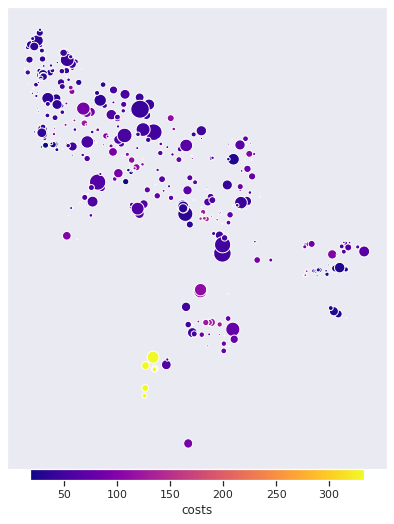

In [310]:
import numpy as np

cluster_shapes = gpd.read_file('outs/cluster.shp')

shapes = cluster_shapes.merge(c)
shapes[shapes.disthash.isin(final_clusters)]

# shapes['base_cost'] = np.sqrt(shapes.base_cost)
# shapes['optimized_cost'] = np.sqrt(shapes.optimized_cost)

shapes['log_base_cost'] = np.log(shapes.base_cost)
shapes['log_optimized_cost'] = np.log(shapes.optimized_cost)
plot_incidence_map(shapes, {'var': 'base_cost', 'title': 'costs'}, 'plasma')
# plt.savefig('spending-map-naive.png', bbox_inches='tight', dpi=300)

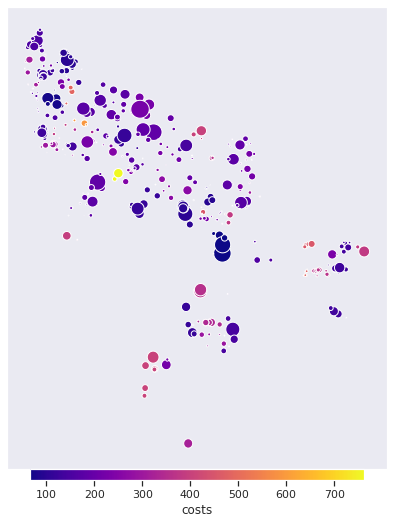

In [311]:
plot_incidence_map(shapes, {'var': 'optimized_cost', 'title': 'costs'})